<a href="https://colab.research.google.com/github/Charles980903/Proj2/blob/main/Another_copy_of_Untitled5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests

try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x, total, unit: x  # If tqdm doesn't exist, replace it with a function that does nothing
    print('**** Could not import tqdm. Please install tqdm for download progressbars! (pip install tqdm) ****')

# Python2 compatibility
try:
    input = raw_input
except NameError:
    pass

download_dict = {
    '1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)': {
        '1) MNIST data format (ubyte.gz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/train-labels-idx1-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-images-idx3-ubyte.gz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/t10k-labels-idx1-ubyte.gz'],
        '2) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'],
    },
    '2) Kuzushiji-49 (49 classes, 28x28, 270k examples)': {
        '1) NumPy data format (.npz)':
            ['http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-train-labels.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-imgs.npz',
            'http://codh.rois.ac.jp/kmnist/dataset/k49/k49-test-labels.npz'],
    },
    '3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)': {
        '1) Folders of images (.tar)':
            ['http://codh.rois.ac.jp/kmnist/dataset/kkanji/kkanji.tar'],
    }

}

# Download a list of files
def download_list(url_list):
    for url in url_list:
        path = url.split('/')[-1]
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))

            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)
    print('All dataset files downloaded!')

# Ask the user about which path to take down the dict
def traverse_dict(d):
    print('Please select a download option:')
    keys = sorted(d.keys())  # Print download options
    for key in keys:
        print(key)

    userinput = input('> ').strip()

    try:
        selection = int(userinput) - 1
    except ValueError:
        print('Your selection was not valid')
        traverse_dict(d)  # Try again if input was not valid
        return

    selected = keys[selection]

    next_level = d[selected]
    if isinstance(next_level, list):  # If we've hit a list of downloads, download that list
        download_list(next_level)
    else:
        traverse_dict(next_level)     # Otherwise, repeat with the next level

traverse_dict(download_dict)

Please select a download option:
1) Kuzushiji-MNIST (10 classes, 28x28, 70k examples)
2) Kuzushiji-49 (49 classes, 28x28, 270k examples)
3) Kuzushiji-Kanji (3832 classes, 64x64, 140k examples)
> 1
Please select a download option:
1) MNIST data format (ubyte.gz)
2) NumPy data format (.npz)
> 2


100%|██████████| 17954/17954 [00:11<00:00, 1602.40KB/s]


100%|██████████| 30/30 [00:00<00:00, 326.78KB/s]


100%|██████████| 3008/3008 [00:02<00:00, 1281.05KB/s]


100%|██████████| 6/6 [00:00<00:00, 19433.07KB/s]

All dataset files downloaded!


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,ConfusionMatrixDisplay
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import os
import random
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time

def set_seed(seed=42):
    """Ensure reproducibility by setting random seeds."""
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    tf.config.experimental.enable_op_determinism()
set_seed(42)


def log_time(step_name, start_time):
    end_time = time.time()
    print(f"{step_name} completed in {end_time - start_time:.2f} seconds.")
    return end_time

In [ ]:
# Load the Kuzushiji-MNIST data
train_images = np.load('kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('kmnist-train-labels.npz')['arr_0']
test_images = np.load('kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('kmnist-test-labels.npz')['arr_0']

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Flatten the images for input into the Stacked Autoencoder
train_images_flattened = train_images.reshape(-1, 784)
test_images_flattened = test_images.reshape(-1, 784)

x_test = test_images_flattened
y_test = test_labels

# Split the training data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(train_images_flattened, train_labels, test_size=0.2, random_state=42)


In [ ]:
def build_sae(bottleneck_size):
    # Encoder
    input_layer = Input(shape=(784,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_size, activation='relu', name="bottleneck")(encoder)

    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(bottleneck)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(784, activation='sigmoid', name="output_layer")(decoder)

    # Build model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

In [ ]:

def extract_features(autoencoder, data):

    encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)
    features = encoder_model.predict(data)
    return features

Training SAE with bottleneck size 32, batch size 64, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 64, Patience 5 - CV Accuracy: 0.9597
Training SAE with bottleneck size 32, batch size 64, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 64, Patience 10 - CV Accuracy: 0.9572
Training SAE with bottleneck size 32, batch size 128, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 128, Patience 5 - CV Accuracy: 0.9585
Training SAE with bottleneck size 32, batch size 128, patience 10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 32, Batch size 128, Patience 10 - CV Accuracy: 0.9610
Training SAE with bottleneck size 64, batch size 64, patience 5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━

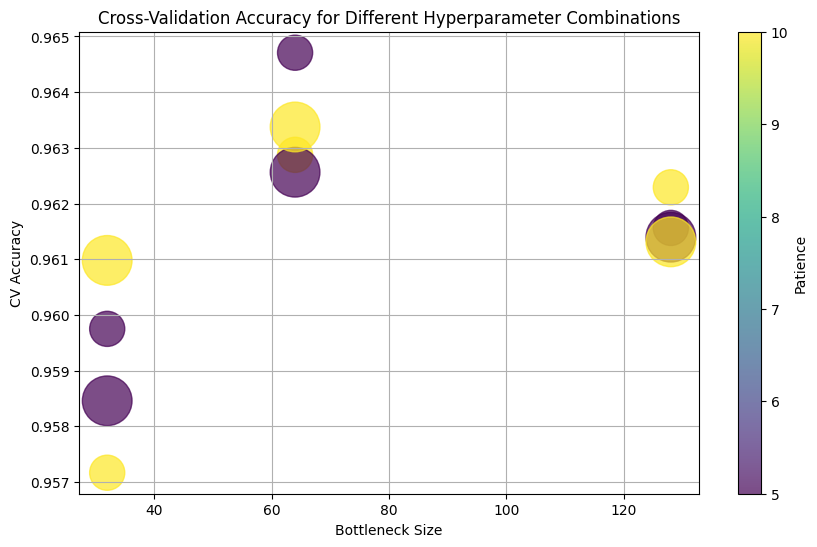

In [ ]:
from itertools import product



# Define ranges for hyperparameters to test
bottleneck_sizes = [32, 64, 128]
batch_sizes = [64, 128]
patience_values = [5, 10]


cv_results = {}



for bottleneck_size, batch_size, patience in product(bottleneck_sizes, batch_sizes, patience_values):
    print(f"Training SAE with bottleneck size {bottleneck_size}, batch size {batch_size}, patience {patience}")

    # Build the autoencoder
    autoencoder = build_sae(bottleneck_size)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(
        x_train, x_train,
        epochs=50,  # Set a high epoch limit, early stopping will determine the actual stopping point
        batch_size=batch_size,
        validation_data=(x_val, x_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    val_features = extract_features(autoencoder, x_val)

    # Scale the features for the SVM classifier
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # Train an SVM classifier using cross-validation
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    scores = cross_val_score(svm_classifier, train_features_scaled, y_train, cv=5)
    avg_accuracy = np.mean(scores)

    # Store the results
    cv_results[(bottleneck_size, batch_size, patience)] = avg_accuracy
    print(f"Bottleneck size {bottleneck_size}, Batch size {batch_size}, Patience {patience} - CV Accuracy: {avg_accuracy:.4f}")


best_params = max(cv_results, key=cv_results.get)
best_accuracy = cv_results[best_params]
print(f"\nBest parameters: Bottleneck size = {best_params[0]}, Batch size = {best_params[1]}, Patience = {best_params[2]}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")

# Plot the cross-validation results
bottleneck_sizes_plot, batch_sizes_plot, patience_plot, accuracies = zip(*[(k[0], k[1], k[2], v) for k, v in cv_results.items()])
plt.figure(figsize=(10, 6))
plt.scatter(bottleneck_sizes_plot, accuracies, c=patience_plot, cmap='viridis', s=[10 * b for b in batch_sizes_plot], alpha=0.7)
plt.colorbar(label='Patience')
plt.title('Cross-Validation Accuracy for Different Hyperparameter Combinations')
plt.xlabel('Bottleneck Size')
plt.ylabel('CV Accuracy')
plt.grid(True)
plt.show()


In [ ]:
from itertools import product
bottleneck_sizes = [48,52,56,60,64,68,72,74]



cv_results = {}



for bottleneck_size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {bottleneck_size}")

    # Build the autoencoder
    autoencoder = build_sae(bottleneck_size)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the autoencoder with early stopping
    autoencoder.fit(
        x_train, x_train,
        epochs=50,  # Set a high epoch limit, early stopping will determine the actual stopping point
        batch_size=64,
        validation_data=(x_val, x_val),
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    val_features = extract_features(autoencoder, x_val)

    # Scale the features for the SVM classifier
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    val_features_scaled = scaler.transform(val_features)

    # Train an SVM classifier using cross-validation
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    scores = cross_val_score(svm_classifier, train_features_scaled, y_train, cv=5)
    avg_accuracy = np.mean(scores)

    # Store the results
    cv_results[(bottleneck_size)] = avg_accuracy
    print(f"Bottleneck size {bottleneck_size} - CV Accuracy: {avg_accuracy:.4f}")





Training SAE with bottleneck size 48
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 48 - CV Accuracy: 0.9623
Training SAE with bottleneck size 52
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 52 - CV Accuracy: 0.9620
Training SAE with bottleneck size 56
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 56 - CV Accuracy: 0.9627
Training SAE with bottleneck size 60
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 60 - CV Accuracy: 0.9640
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 64 - CV Accuracy: 0.9643
Training SAE with bottleneck size 68
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Bottleneck size 68 - CV Accuracy: 0.9641
Training SAE with bottleneck

TypeError: 'int' object is not subscriptable

In [ ]:
best_params = max(cv_results, key=cv_results.get)
best_accuracy = cv_results[best_params]
print(f"\nBest parameters: Bottleneck size = {best_params}")
print(f"Best CV Accuracy: {best_accuracy:.4f}")


Best parameters: Bottleneck size = 64
Best CV Accuracy: 0.9643


Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0767 - val_loss: 0.0318
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0292 - val_loss: 0.0244
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0232 - val_loss: 0.0226
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0207 - val_loss: 0.0201
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0191 - val_loss: 0.0192
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0183 - val_loss: 0.0183
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0176 - val_loss: 0.0184
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0171 - val_loss: 0.0189
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0165 - val_loss: 0.0181
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0155 - val_loss: 0.0173
Epoch 12/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

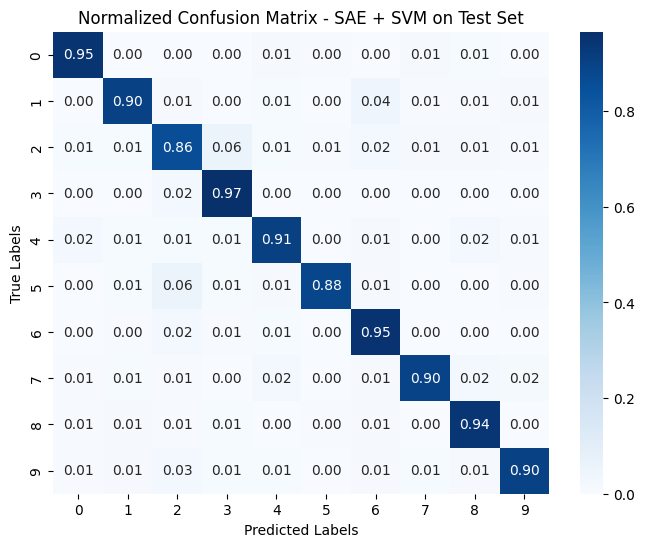

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

time_train_saesvm = time.time()

# Build and compile the autoencoder
autoencoder = build_sae(64)
autoencoder.compile(optimizer='adam', loss='mse')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train on the entire training set
autoencoder.fit(
    x_train, x_train,
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),
    callbacks=[early_stopping],
    verbose=1
)

# Step 2: Extract Bottleneck Features
train_features = extract_features(autoencoder, x_train)
test_features = extract_features(autoencoder, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Step 4: Train the SVM Classifier on the Extracted Features
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(train_features_scaled, y_train)

# Step 5: Evaluate on the Test Set
test_predictions = svm_classifier.predict(test_features_scaled)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\nSAE + SVM Test Accuracy: {test_accuracy:.4f}")
log_time("Train SAE+SVM time", time_train_saesvm)

# Step 6: Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
sae_total_params = autoencoder.count_params()
print(f"Total parameters in SAE model: {sae_total_params}")

Total parameters in SAE model: 1602848


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step


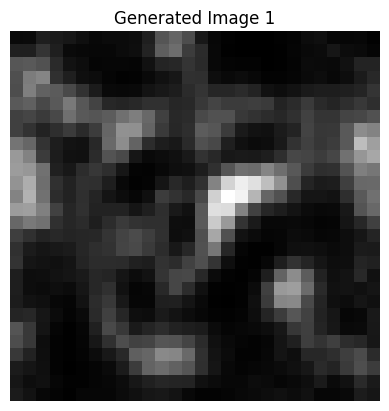

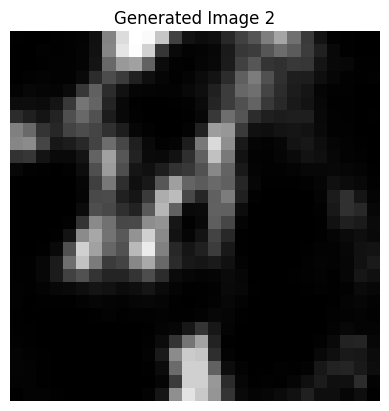

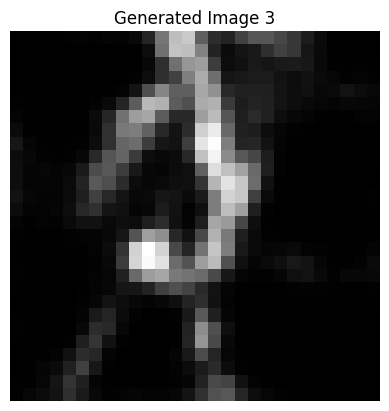

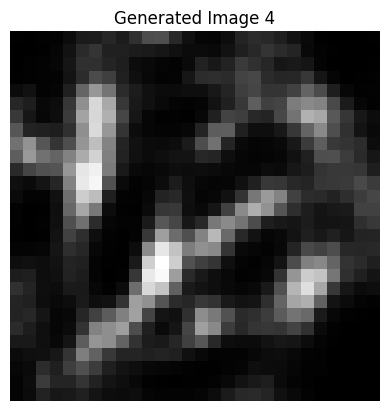

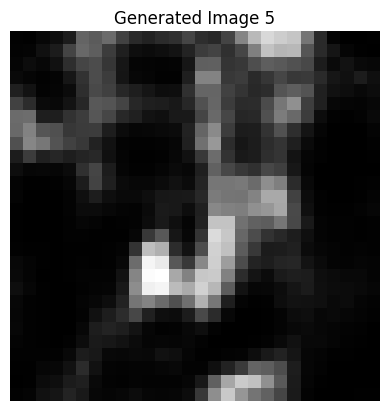

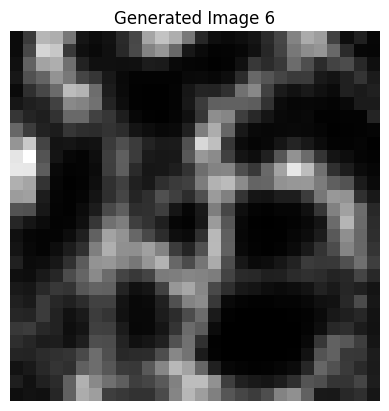

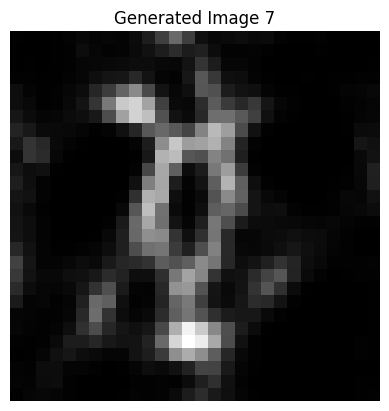

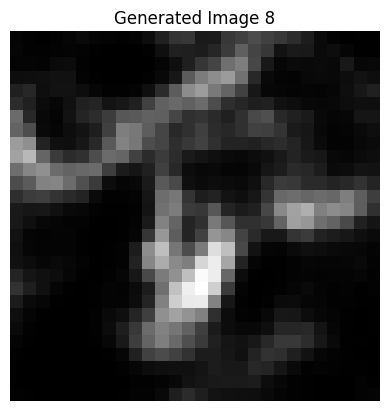

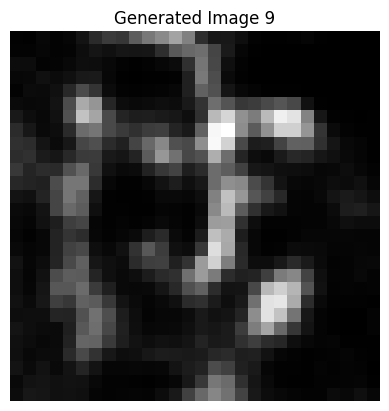

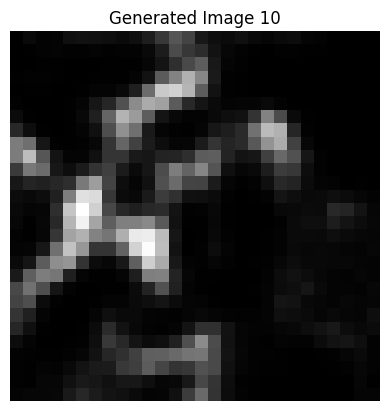

In [ ]:
# Extract the decoder from the trained autoencoder
def extract_decoder(autoencoder):
    """
    Extracts the decoder from the trained autoencoder.
    """
    # Define the bottleneck layer input manually
    bottleneck_dim = autoencoder.get_layer('bottleneck').units  # Get the number of units in bottleneck layer
    decoder_input = Input(shape=(bottleneck_dim,), name="decoder_input")

    # Connect the decoder layers to the bottleneck input
    decoder_output = autoencoder.get_layer('decoder_1')(decoder_input)
    decoder_output = autoencoder.get_layer('decoder_2')(decoder_output)
    decoder_output = autoencoder.get_layer('output_layer')(decoder_output)

    # Create the decoder model
    decoder = Model(inputs=decoder_input, outputs=decoder_output, name="decoder")
    return decoder

# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Generate bottleneck codes
num_images = 10  # Number of images to generate
bottleneck_size = autoencoder.get_layer('bottleneck').units  # Automatically determine bottleneck size
bottleneck_codes = np.random.normal(0, 1, size=(num_images, bottleneck_size))  # Random latent codes

# Use the decoder to generate images
generated_images = decoder.predict(bottleneck_codes)

# Visualize the generated images
for i in range(num_images):
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')  # Reshape to 28x28 if input size is 784
    plt.title(f"Generated Image {i+1}")
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract representative codes for each class
def extract_representative_codes(autoencoder, x_train, y_train):
    """
    Extract one representative bottleneck code for each class.
    """
    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    representative_codes = []
    for class_label in np.unique(y_train):
        class_indices = np.where(y_train == class_label)[0]
        # Take the first sample from each class
        representative_code = bottleneck_model.predict(x_train[class_indices[:1]])[0]
        representative_codes.append(representative_code)
    return np.array(representative_codes)

# Step 2: Add Gaussian noise to bottleneck codes
def generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=[0.1, 0.2, 0.3]):
    """
    Generate images by adding Gaussian noise to the bottleneck codes.
    """
    num_classes = len(representative_codes)
    images_per_class = num_images // num_classes
    augmented_images = []
    augmented_labels = []

    for variance in noise_variances:
        for class_idx, code in enumerate(representative_codes):
            for _ in range(images_per_class // len(noise_variances)):
                noisy_code = code + np.random.normal(0, variance, size=code.shape)
                generated_image = decoder.predict(np.expand_dims(noisy_code, axis=0))[0]
                augmented_images.append(generated_image)
                augmented_labels.append(class_idx)

    return np.array(augmented_images), np.array(augmented_labels)

# Step 3: Generate and visualize images
# Extract the trained decoder
decoder = extract_decoder(autoencoder)

# Extract representative codes for each class
representative_codes = extract_representative_codes(autoencoder, x_train, y_train)

# Generate 1,000 noisy images
noise_variances = [0.1, 0.2, 0.3]
augmented_images, augmented_labels = generate_noisy_images(decoder, representative_codes, num_images=1000, noise_variances=noise_variances)




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0738 - val_loss: 0.0322
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0289 - val_loss: 0.0255
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0236 - val_loss: 0.0229
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0211 - val_loss: 0.0218
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0199 - val_loss: 0.0205
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0190 - val_loss: 0.0205
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0184 - val_loss: 0.0201
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0179 - val_loss: 0.0208
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0176 - val_loss: 0.0198
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0174 - val_loss: 0.0192
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0172 - val_loss: 0.0192
Epoch 12/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step

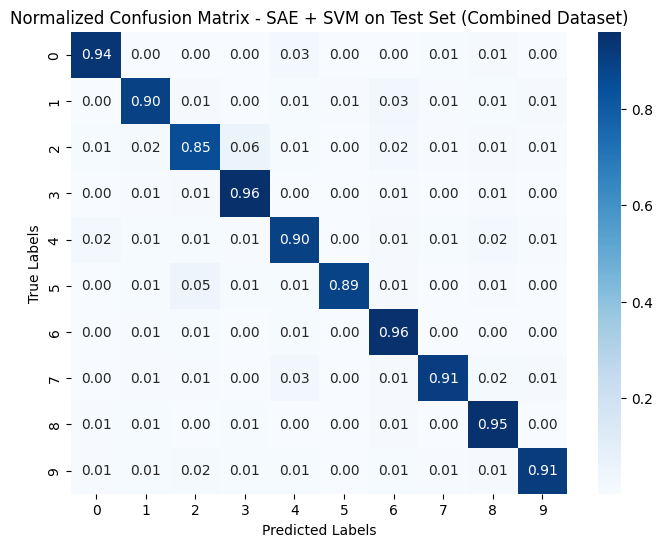

In [ ]:
# Combine original and newly generated data
combined_train_images = np.vstack([x_train, augmented_images])  # Combine original and generated images
combined_train_labels = np.hstack([y_train, augmented_labels])  # Combine corresponding labels

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Step 1: Train the autoencoder on the combined training dataset

autoencoder_augmented = build_sae(64)
autoencoder_augmented.compile(optimizer='adam', loss='mse')
start_time = time.time()
autoencoder_augmented.fit(
    combined_train_images, combined_train_images,  # Train on combined dataset
    epochs=50,
    batch_size=64,
    validation_data=(x_val, x_val),  # Validation set remains the same
    callbacks=[early_stopping],
    verbose=1
)
training_time = time.time() - start_time
print(f"Training Time (Combined Dataset): {training_time:.2f} seconds")

# Step 2: Extract Bottleneck Features
train_features_combined = extract_features(autoencoder_augmented, combined_train_images)
test_features_combined = extract_features(autoencoder_augmented, x_test)

# Step 3: Scale the Features
scaler = StandardScaler()
train_features_scaled_combined = scaler.fit_transform(train_features_combined)
test_features_scaled_combined = scaler.transform(test_features_combined)

# Step 4: Train the SVM Classifier on the Combined Dataset
start_time_svm = time.time()
svm_classifier_combined = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_combined.fit(train_features_scaled_combined, combined_train_labels)
svm_training_time = time.time() - start_time_svm

# Step 5: Evaluate on the Test Set
test_predictions_combined = svm_classifier_combined.predict(test_features_scaled_combined)
test_accuracy_combined = accuracy_score(y_test, test_predictions_combined)

print(f"\nSAE + SVM Test Accuracy (Combined Dataset): {test_accuracy_combined:.4f}")
print(f"SVM Training Time (Combined Dataset): {svm_training_time:.2f} seconds")

# Step 6: Generate Confusion Matrix and Classification Report
cm_combined = confusion_matrix(y_test, test_predictions_combined, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_combined, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM on Test Set (Combined Dataset)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6480 - loss: 1.0611 - val_accuracy: 0.8793 - val_loss: 0.3830
Epoch 2/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9046 - loss: 0.3117 - val_accuracy: 0.9078 - val_loss: 0.2990
Epoch 3/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9371 - loss: 0.2068 - val_accuracy: 0.9197 - val_loss: 0.2661
Epoch 4/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9561 - loss: 0.1459 - val_accuracy: 0.9270 - val_loss: 0.2561
Epoch 5/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9701 - loss: 0.1039 - val_accuracy: 0.9342 - val_loss: 0.2392
Epoch 6/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9759 - loss: 0.0775 - val_accuracy: 0.9516 - val_loss: 0.1794
Epoch 7/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9821 - loss: 0.0584 - val_accuracy: 0.9526 - val_loss: 0.1836
Epoch 8/100
766/766 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9850 - loss: 0.0450 - val_accu

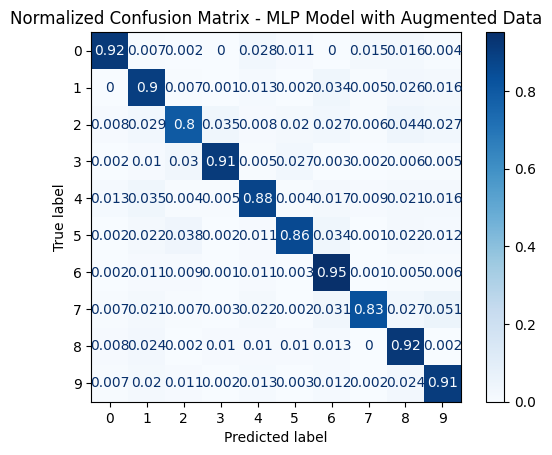

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt




x_test_processed = test_images.reshape(test_images.shape[0], -1) / 255.0  # Process test data similarly

# One-hot encode the labels
y_train_augmented_one_hot = tf.one_hot(combined_train_labels, depth=10)
test_labels_one_hot = tf.one_hot(test_labels, depth=10)
val_labels_one_hot = tf.one_hot(y_val, depth=10)

# Define the MLP model
num_layers = 3
num_units = 512
learning_rate = 0.001
patience = 10

time_augmented_MLP = time.time()

model = Sequential([Flatten(input_shape=(28 * 28,))])  # Input shape matches the flattened image dimensions
for _ in range(num_layers):
    model.add(Dense(num_units, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)

# Train the MLP with augmented data
history = model.fit(combined_train_images, y_train_augmented_one_hot, epochs=100,
                    validation_data=(x_val, val_labels_one_hot),
                    batch_size=64, callbacks=[early_stopping], verbose=1)


# Evaluate the model
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
y_true = test_labels  # Keep test labels as integers for confusion matrix

# Calculate accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Calculate normalized confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, normalize='true')

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title("Normalized Confusion Matrix - MLP Model with Augmented Data")
plt.show()


Training SAE with bottleneck size 16
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


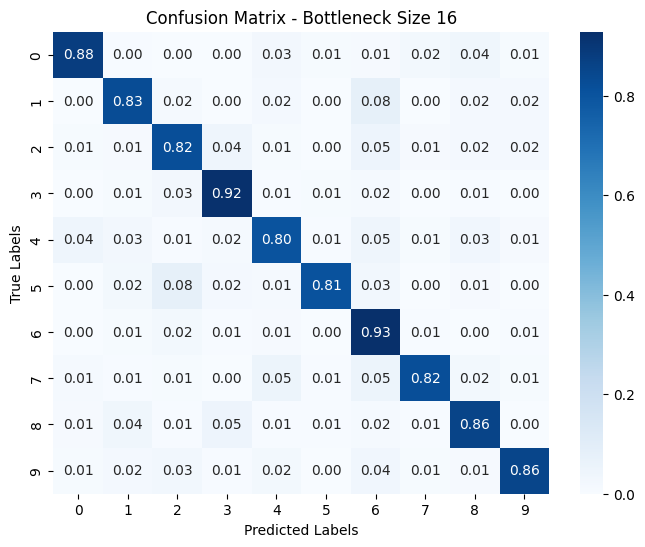

Bottleneck size 16 - Test Accuracy: 0.8529
Training SAE with bottleneck size 32
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


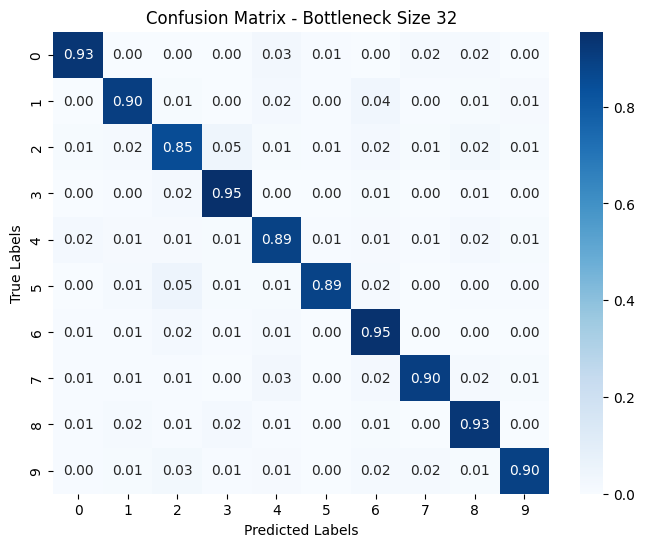

Bottleneck size 32 - Test Accuracy: 0.9080
Training SAE with bottleneck size 64
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


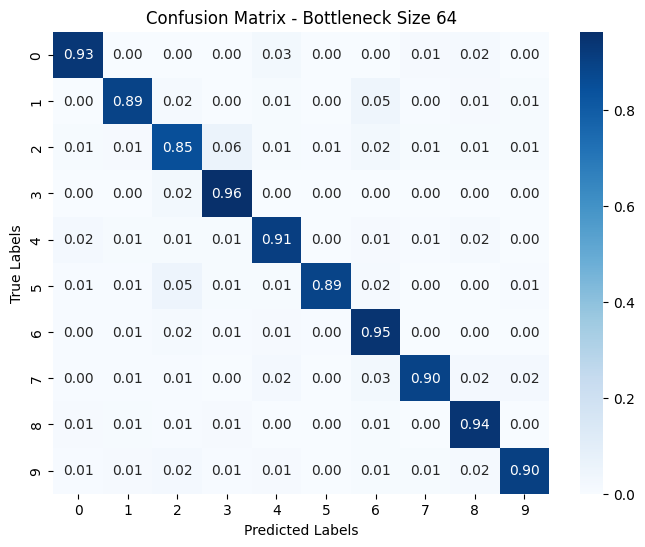

Bottleneck size 64 - Test Accuracy: 0.9131
Training SAE with bottleneck size 128
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


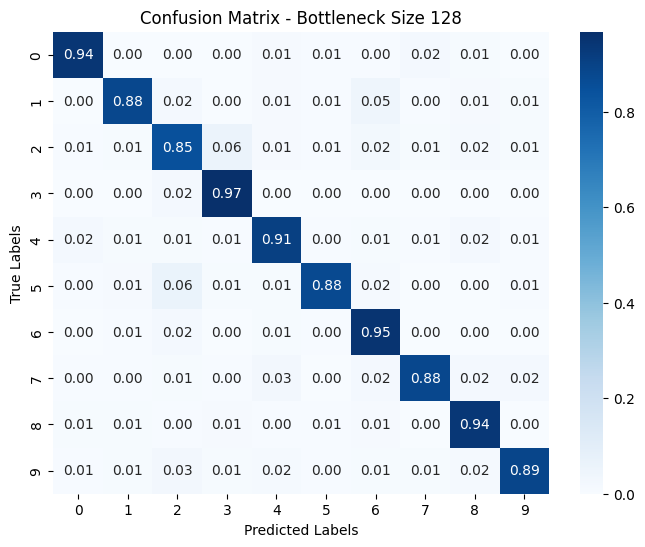

Bottleneck size 128 - Test Accuracy: 0.9096
Training SAE with bottleneck size 256
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


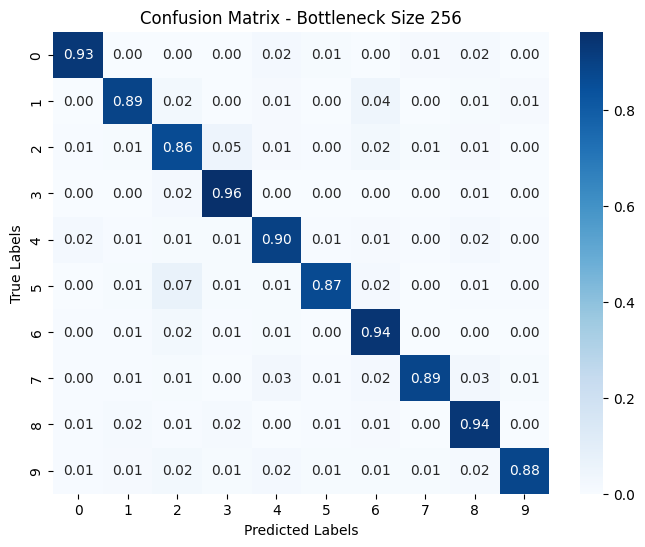

Bottleneck size 256 - Test Accuracy: 0.9059
Training SAE with bottleneck size 400
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


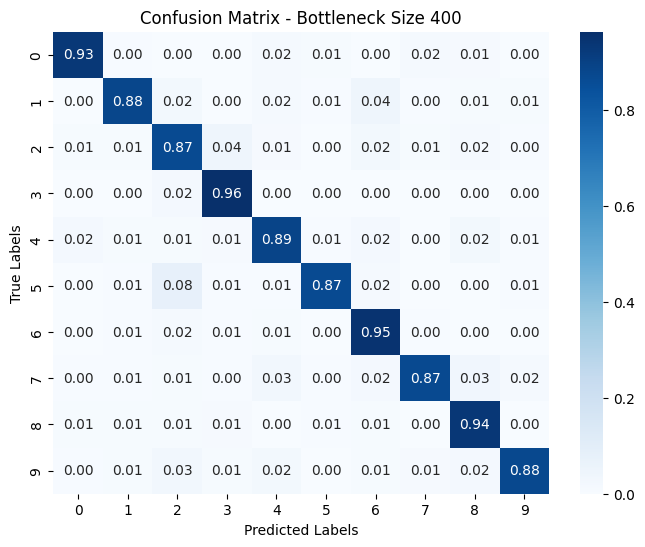

Bottleneck size 400 - Test Accuracy: 0.9037


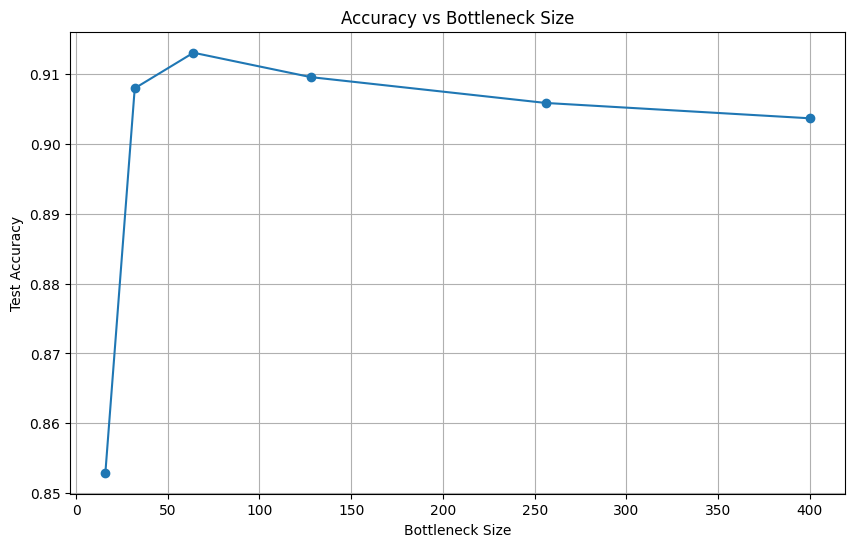

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import numpy as np


def plot_confusion_matrix(y_true, y_pred, title):
    """Plot a normalized confusion matrix."""
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f')
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

# Define bottleneck sizes to evaluate
bottleneck_sizes = [16, 32, 64, 128, 256, 400]
accuracies = []

for size in bottleneck_sizes:
    print(f"Training SAE with bottleneck size {size}")

    # Train the SAE with current bottleneck size
    autoencoder = build_sae(size)
    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.fit(x_train, x_train, epochs=50, batch_size=64, validation_data=(x_val, x_val), verbose=0)

    # Extract features from the bottleneck layer
    train_features = extract_features(autoencoder, x_train)
    test_features = extract_features(autoencoder, x_test)

    # Scale features
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_features)
    test_features_scaled = scaler.transform(test_features)

    # Train the SVM on the extracted features
    svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_classifier.fit(train_features_scaled, y_train)

    # Predict on the test set
    test_predictions = svm_classifier.predict(test_features_scaled)
    accuracy = accuracy_score(y_test, test_predictions)
    accuracies.append(accuracy)

    # Plot the confusion matrix for the current bottleneck size
    plot_confusion_matrix(y_test, test_predictions, f"Confusion Matrix - Bottleneck Size {size}")
    print(f"Bottleneck size {size} - Test Accuracy: {accuracy:.4f}")

# Plot the bottleneck size vs accuracy
plt.figure(figsize=(10, 6))
plt.plot(bottleneck_sizes, accuracies, marker='o')
plt.title("Accuracy vs Bottleneck Size")
plt.xlabel("Bottleneck Size")
plt.ylabel("Test Accuracy")
plt.grid(True)
plt.show()


## Part 2

In [ ]:

from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Flatten images for input into the SAE
x_train = train_images.reshape(-1, 784)
x_test = test_images.reshape(-1, 784)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, train_labels, test_size=0.2, random_state=42)

# One-hot encode labels
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)
y_test = to_categorical(test_labels, num_classes=10)


In [ ]:
num_classes = 10
bottleneck_dim = 10  # Bottleneck size

np.random.seed(42)
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


In [ ]:
from sklearn.preprocessing import normalize
from tensorflow.keras.layers import Input, Dense, Layer


def generate_orthogonal_vectors(num_classes, bottleneck_dim):
    """
    Generate orthogonal vectors for the penalty layer targets.
    """
    random_matrix = np.random.randn(num_classes, bottleneck_dim)
    orthogonal_matrix, _ = np.linalg.qr(random_matrix)
    orthogonal_matrix = normalize(orthogonal_matrix, axis=1)
    return orthogonal_matrix

class PenaltyLayer(Layer):
    def __init__(self, targets, lambda_penalty, distance_metric='euclidean', p=3, **kwargs):
        super(PenaltyLayer, self).__init__(**kwargs)
        self.targets = targets
        self.lambda_penalty = lambda_penalty
        self.distance_metric = distance_metric
        self.p = p  # Minkowski parameter

    def call(self, bottleneck_outputs, labels):
        targets_batch = tf.gather(self.targets, tf.argmax(labels, axis=1))

        if self.distance_metric == 'manhattan':
            distances = tf.reduce_sum(tf.abs(bottleneck_outputs - targets_batch), axis=1)
        elif self.distance_metric == 'minkowski':
            distances = tf.reduce_sum(tf.pow(tf.abs(bottleneck_outputs - targets_batch), self.p), axis=1)
            distances = tf.pow(distances, 1.0 / self.p)
        else:  # Euclidean
            squared_diff = tf.square(bottleneck_outputs - targets_batch)
            distances = tf.sqrt(tf.reduce_sum(squared_diff, axis=1))

        penalty_R = tf.reduce_mean(distances)
        self.add_loss(self.lambda_penalty * penalty_R)
        return bottleneck_outputs


def create_custom_loss(model):
    def custom_loss(y_true, y_pred):
        reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))
        penalty_term = sum(model.losses)
        total_loss = reconstruction_loss + penalty_term
        return total_loss
    return custom_loss

def extract_bottleneck_features(autoencoder, x_data):
    bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
    return bottleneck_model.predict(x_data)

def train_svm(features_train, labels_train, features_test, labels_test):
    svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)
    svm_classifier.fit(features_train, np.argmax(labels_train, axis=1))
    train_accuracy = svm_classifier.score(features_train, np.argmax(labels_train, axis=1))
    test_accuracy = svm_classifier.score(features_test, np.argmax(labels_test, axis=1))
    return train_accuracy, test_accuracy

In [ ]:
# Generate the target sets
direct_targets = tf.convert_to_tensor(np.eye(num_classes), dtype=tf.float32)

custom_targets = np.random.randn(num_classes, bottleneck_dim)
custom_targets = custom_targets / np.linalg.norm(custom_targets, axis=1, keepdims=True)
custom_targets = tf.convert_to_tensor(custom_targets, dtype=tf.float32)

orthogonal_targets = generate_orthogonal_vectors(num_classes=num_classes, bottleneck_dim=bottleneck_dim)
orthogonal_targets_tensor = tf.convert_to_tensor(orthogonal_targets, dtype=tf.float32)


random_diagonal_matrix = np.zeros((num_classes, bottleneck_dim))
diag_length = min(num_classes, bottleneck_dim)
diagonal_values = np.random.randn(diag_length)
for i in range(diag_length):
    random_diagonal_matrix[i, i] = diagonal_values[i]
random_diagonal_targets_tensor = tf.convert_to_tensor(random_diagonal_matrix, dtype=tf.float32)


target_sets = [direct_targets, custom_targets, orthogonal_targets_tensor, random_diagonal_targets_tensor]
target_names = ["Direct Assignment", "Custom Random Vectors", "Orthogonal Vectors","diagonal_targets_tensor"]

In [ ]:


def evaluate_R(x_data, y_data):
    # Get bottleneck outputs
    bottleneck_outputs = bottleneck_model.predict(x_data)  # Shape: (batch_size, bottleneck_dim)
    y_labels = np.argmax(y_data, axis=1)  # Convert one-hot to class labels, Shape: (batch_size,)

    # Gather target vectors corresponding to the labels
    targets_batch = tf.gather(targets_tensor, y_labels)  # Shape: (batch_size, bottleneck_dim)

    # Compute penalty R
    squared_diff = tf.square(bottleneck_outputs - targets_batch)
    distances = tf.reduce_sum(squared_diff, axis=1)
    penalty_R = tf.reduce_mean(distances)
    return penalty_R.numpy()





In [ ]:
# Step 3: Define SAE architecture
def build_sae_with_penalty(input_dim, bottleneck_dim, targets_tensor, lambda_penalty):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(800, activation='relu')(input_layer)
    encoder = Dense(200, activation='relu')(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(encoder)

    labels_input = Input(shape=(num_classes,), name='labels')
    # Placeholder for the penalty layer (to be added later)
    penalty_layer = bottleneck

    decoder = Dense(200, activation='relu')(penalty_layer)
    decoder = Dense(800, activation='relu')(decoder)
    output_layer = Dense(input_dim, activation='sigmoid')(decoder)

    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
    return autoencoder

# Step 4: Train and evaluate each SAE
def train_and_evaluate(autoencoder, targets_tensor, x_train, y_train, x_test, y_test):
    autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
    autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)
    features_train = extract_bottleneck_features(autoencoder, x_train)
    features_test = extract_bottleneck_features(autoencoder, x_test)
    return train_svm(features_train, y_train, features_test, y_test)

In [ ]:
lambda_penalty = 0.1
distance_metrics = ['euclidean', 'manhattan','minkowski']
results = []

for target_idx, (targets_tensor, target_name) in enumerate(zip(target_sets, target_names)):
    for distance_metric in distance_metrics:
        print(f"\nTraining with {target_name}, Distance Metric: {distance_metric}")

        # Build SAE model
        autoencoder = build_sae(
            input_dim=784,
            bottleneck_dim=10,
            targets_tensor=targets_tensor,
            lambda_penalty=lambda_penalty
        )

        # Replace bottleneck with a distance penalty layer
        bottleneck_layer = autoencoder.get_layer("bottleneck").output
        labels_input = autoencoder.input[1]
        penalty_layer = PenaltyLayer(
            targets=targets_tensor,
            lambda_penalty=lambda_penalty,
            distance_metric=distance_metric
        )(bottleneck_layer, labels_input)

        # Update the model with the new penalty layer
        decoder_input = penalty_layer
        for layer in autoencoder.layers[-3:]:  # Decoder layers
            decoder_input = layer(decoder_input)

        autoencoder = Model(inputs=autoencoder.inputs, outputs=decoder_input)

        # Compile and train the autoencoder
        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))
        autoencoder.fit([x_train, y_train], x_train, epochs=20, batch_size=64, verbose=1)

        # Extract features
        train_features = extract_bottleneck_features(autoencoder, x_train)
        test_features = extract_bottleneck_features(autoencoder, x_test)

        # Train and evaluate SVM
        train_acc, test_acc = train_svm(train_features, y_train, test_features, y_test)

        # Store results
        results.append({
            'Target Method': target_name,
            'Distance Metric': distance_metric,
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        })


Training with Direct Assignment, Distance Metric: euclidean
Epoch 1/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2022
Epoch 2/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1264
Epoch 3/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1101
Epoch 4/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0999
Epoch 5/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0935
Epoch 6/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0882
Epoch 7/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0840
Epoch 8/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0810
Epoch 9/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0781
Epoch 10/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0760
Epoch 11/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0743
Epoch 12/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0725
Epoch 13/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0714
Epoch 14/20
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0

In [ ]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame(results)
print(results_df)


              Target Method Distance Metric  Train Accuracy  Test Accuracy
0         Direct Assignment       euclidean        0.992563         0.8945
1         Direct Assignment       manhattan        0.100937         0.1000
2         Direct Assignment       minkowski        0.994479         0.9003
3     Custom Random Vectors       euclidean        0.992750         0.8924
4     Custom Random Vectors       manhattan        0.993250         0.8885
5     Custom Random Vectors       minkowski        0.993104         0.8981
6        Orthogonal Vectors       euclidean        0.991854         0.8930
7        Orthogonal Vectors       manhattan        0.992750         0.8909
8        Orthogonal Vectors       minkowski        0.991437         0.8966
9   diagonal_targets_tensor       euclidean        0.977000         0.8575
10  diagonal_targets_tensor       manhattan        0.100937         0.1000
11  diagonal_targets_tensor       minkowski        0.979313         0.8674


In [ ]:
def generate_target_sets(num_classes, bottleneck_dim, num_sets):
    target_sets = []
    for _ in range(num_sets):
        targets = np.random.randn(num_classes, bottleneck_dim)
        targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)
        target_sets.append(tf.convert_to_tensor(targets, dtype=tf.float32))
    return target_sets

# Generate 5 different target sets
num_target_sets = 3
target_sets = generate_target_sets(num_classes=10, bottleneck_dim=64, num_sets=num_target_sets)


In [ ]:
# Define lambda values
lambda_values = [0.001, 0.01, 0.1, 0.2, 0.4, 0.8, 1]

# Results storage
results_3d = []

# Loop through each target set and lambda value
for target_index, targets_tensor in enumerate(target_sets):
    for lambda_penalty in lambda_values:
        print(f"\nTraining with Target Set {target_index + 1}, Lambda={lambda_penalty}...")

        # Define the input layers
        input_layer = Input(shape=(784,), name="input_layer")
        labels_input = Input(shape=(num_classes,), name="labels_input")

        # Build the SAE with the current target set and lambda
        encoder = Dense(800, activation='relu')(input_layer)
        encoder = Dense(200, activation='relu')(encoder)
        bottleneck = Dense(64, activation='linear', name='bottleneck')(encoder)

        penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty=lambda_penalty)(bottleneck, labels_input)

        decoder = Dense(200, activation='relu')(penalty_layer)
        decoder = Dense(800, activation='relu')(decoder)
        output_layer = Dense(784, activation='sigmoid')(decoder)

        autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer)
        autoencoder.compile(optimizer='adam', loss=create_custom_loss(autoencoder))

        # Train the SAE
        autoencoder.fit(
            [x_train, y_train], x_train,
            validation_data=([x_val, y_val], x_val),
            epochs=25,
            batch_size=64,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
            verbose=0
        )

        # Extract bottleneck features for validation set
        bottleneck_model = Model(inputs=autoencoder.input[0], outputs=autoencoder.get_layer('bottleneck').output)
        latent_val = bottleneck_model.predict(x_val)

        # Evaluate penalty R on validation set
        penalty_R = evaluate_R(x_val, y_val)

        # Train and evaluate SVM accuracy on the extracted bottleneck features
        svm = SVC(kernel='linear', C=1.0)
        svm.fit(latent_val, np.argmax(y_val, axis=1))
        val_acc = svm.score(latent_val, np.argmax(y_val, axis=1))

        # Store the results
        results_3d.append({
            'target_set': target_index + 1,
            'lambda': lambda_penalty,
            'penalty_R': penalty_R,
            'accuracy': val_acc
        })

        print(f"Penalty R: {penalty_R:.4f}, Accuracy: {val_acc:.4f}")




Training with Target Set 1, Lambda=0.001...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.6441, Accuracy: 0.8880

Training with Target Set 1, Lambda=0.01...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.1850, Accuracy: 0.9483

Training with Target Set 1, Lambda=0.1...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Penalty R: 0.0871, Accuracy: 0.9645

Training with Target Set 1, Lambda=0.2...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.0844, Accuracy: 0.9653

Training with Target Set 1, Lambda=0.4...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Penalty R: 0.0783, Accuracy: 0.9677

Training with Target Set 1, Lambda=0.8...
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Penalty R: 0.0811, Accuracy: 0.9656

Training with Target Set 1, La

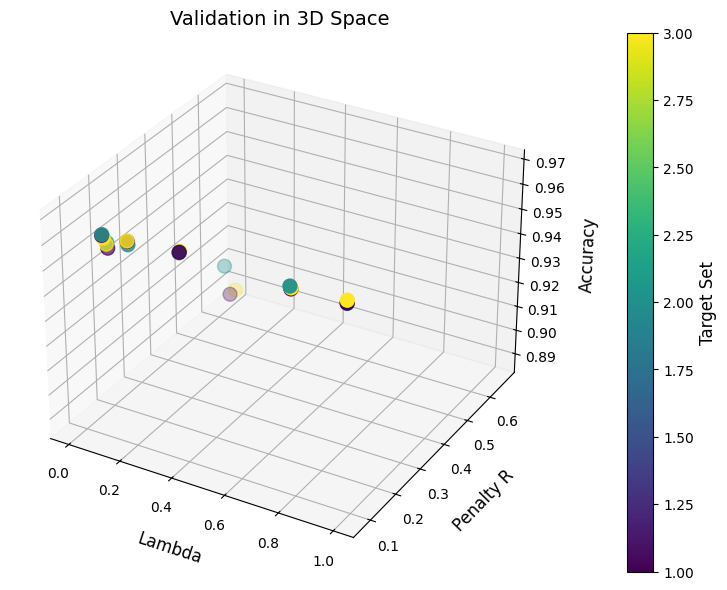

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D


results_df = pd.DataFrame(results_3d)

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(
    results_df['lambda'], results_df['penalty_R'], results_df['accuracy'],
    c=results_df['target_set'], cmap='viridis', s=100
)

# Add a color bar for target sets
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Target Set', fontsize=12)

# Set labels and title
ax.set_xlabel('Lambda', labelpad=10, fontsize=12)
ax.set_ylabel('Penalty R', labelpad=10, fontsize=12)
ax.set_zlabel('Accuracy', labelpad=10, fontsize=12)
ax.set_title('Validation in 3D Space', fontsize=14)

# Adjust tick label sizes
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# Add a grid for better reference
ax.grid(True)

# Show the plot
plt.show()




In [ ]:

num_classes = 10
bottleneck_dim = 64  # Bottleneck size
np.random.seed(42)

# Generate random target vectors of size 64 for each class
targets = np.random.randn(num_classes, bottleneck_dim)
targets = targets / np.linalg.norm(targets, axis=1, keepdims=True)  # Normalize to unit length
targets_tensor = tf.convert_to_tensor(targets, dtype=tf.float32)


Training with batch size: 64
Epoch 1/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6011 - val_loss: 0.2998
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2802 - val_loss: 0.2580
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2368 - val_loss: 0.2448
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.2151 - val_loss: 0.2347
Epoch 5/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.2008 - val_loss: 0.2287
Epoch 6/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1900 - val_loss: 0.2223
Epoch 7/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1798 - val_loss: 0.2211
Epoch 8/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1723 - val_loss: 0.2163
Epoch 9/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.1668 - val_loss: 0.2134
Epoch 10/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1604 - val_loss: 0.2067
Epoch 11/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1559 - val_loss: 0.2045
Epoch 12/50
750/750 ━━

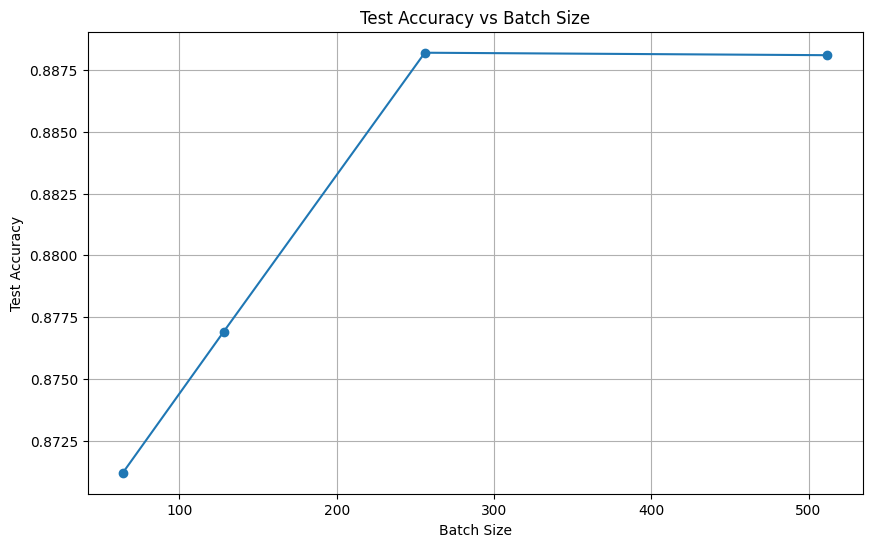

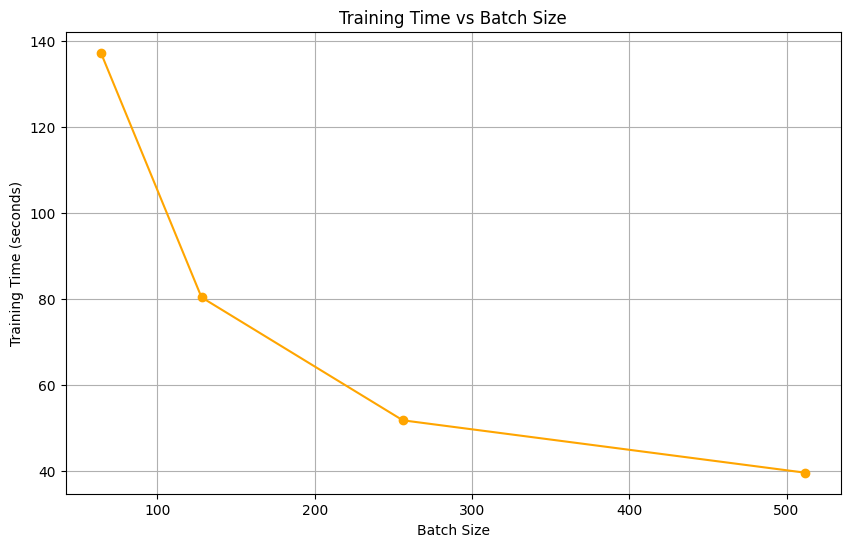

In [17]:
from inspect import EndOfBlock
def build_sae_with_penalty_final(bottleneck_dim, targets_tensor, lambda_penalty, input_dim=784, num_classes=10):

    # Encoder
    input_layer = Input(shape=(input_dim,), name="input_layer")
    encoder = Dense(800, activation='relu', name="encoder_1")(input_layer)
    encoder = Dense(200, activation='relu', name="encoder_2")(encoder)
    bottleneck = Dense(bottleneck_dim, activation='linear', name="bottleneck")(encoder)

    # Penalty Layer
    labels_input = Input(shape=(num_classes,), name="labels_input")  # One-hot labels
    penalty_layer = PenaltyLayer(targets_tensor, lambda_penalty)(bottleneck, labels_input)

    # Decoder
    decoder = Dense(200, activation='relu', name="decoder_1")(penalty_layer)
    decoder = Dense(800, activation='relu', name="decoder_2")(decoder)
    output_layer = Dense(input_dim, activation='sigmoid', name="output_layer")(decoder)

    # Build the model
    autoencoder = Model(inputs=[input_layer, labels_input], outputs=output_layer, name="SAE_with_Penalty")
    return autoencoder


def extract_features_with_penalty(autoencoder, x_data, y_data):

    bottleneck_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('bottleneck').output)
    bottleneck_features = bottleneck_model.predict([x_data, y_data])
    return bottleneck_features



# Define the batch sizes to test
batch_sizes = [64, 128, 256, 512]

# Store results
batch_size_results = []

for batch_size in batch_sizes:
    print(f"\nTraining with batch size: {batch_size}")

    # Define and compile the model
    autoencoder_with_penalty = build_sae_with_penalty_final(
        bottleneck_dim=64,
        lambda_penalty=0.4,
        targets_tensor=targets_tensor
    )
    autoencoder_with_penalty.compile(
        optimizer='adam',
        loss=create_custom_loss(autoencoder_with_penalty)
    )

    # Train the autoencoder
    start_time = time.time()
    history = autoencoder_with_penalty.fit(
        [x_train, y_train], x_train,
        epochs=50,
        batch_size=batch_size,
        validation_data=([x_val, y_val], x_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    # Extract bottleneck features
    train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
    test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)

    # Normalize features
    scaler = StandardScaler()
    train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
    test_features_scaled_penalty = scaler.transform(test_features_penalty)

    # Train SVM classifier
    svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
    svm_classifier_penalty.fit(train_features_scaled_penalty, np.argmax(y_train, axis=1))

    # Evaluate SVM
    test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
    test_accuracy_penalty = accuracy_score(np.argmax(y_test, axis=1), test_predictions_penalty)

    # Store results
    batch_size_results.append({
        "batch_size": batch_size,
        "test_accuracy": test_accuracy_penalty,
        "elapsed_time": elapsed_time
    })
    print(f"Batch size: {batch_size}, Test Accuracy: {test_accuracy_penalty:.4f}, Training Time: {elapsed_time:.2f} seconds")

# Display results as a DataFrame
import pandas as pd
results_df = pd.DataFrame(batch_size_results)
print("\nBatch Size Results:")
print(results_df)

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['test_accuracy'], marker='o')
plt.title('Test Accuracy vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(results_df['batch_size'], results_df['elapsed_time'], marker='o', color='orange')
plt.title('Training Time vs Batch Size')
plt.xlabel('Batch Size')
plt.ylabel('Training Time (seconds)')
plt.grid(True)
plt.show()



In [18]:
# Define SAE architecture with Penalty Layer
autoencoder_with_penalty = build_sae_with_penalty_final(
    bottleneck_dim=64,
    lambda_penalty=0.4,
    targets_tensor=targets_tensor
)

# Compile the autoencoder with a custom loss function
autoencoder_with_penalty.compile(
    optimizer='adam',
    loss=create_custom_loss(autoencoder_with_penalty)
)

# Train the autoencoder with batch size 512
batch_size = 512

start_time = time.time()
history = autoencoder_with_penalty.fit(
    [x_train, y_train], x_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=([x_val, y_val], x_val),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 1.0110 - val_loss: 0.5674
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4819 - val_loss: 0.3704
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3414 - val_loss: 0.3109
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2903 - val_loss: 0.2904
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2636 - val_loss: 0.2754
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2463 - val_loss: 0.2716
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2317 - val_loss: 0.2685
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2221 - val_loss: 0.2565
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2164 - val_loss: 0.2541
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2108 - val_loss: 0.2496
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2054 - val_loss: 0.2469
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.2007 - val_l

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

SAE + SVM Test Accuracy with Penalty: 0.8937
Train SAE+SVM with Penalty time: 29.74 seconds


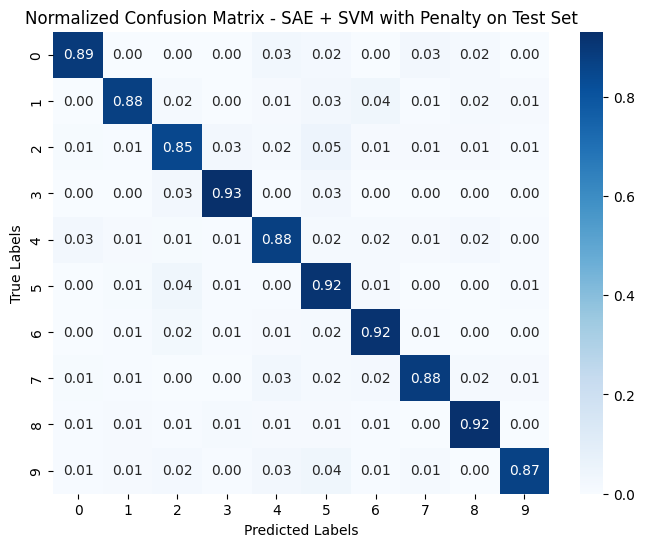

In [19]:
# Step 1: Extract Bottleneck Features for Train and Test Data
train_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_train, y_train)
test_features_penalty = extract_features_with_penalty(autoencoder_with_penalty, x_test, y_test)

# Step 2: Normalize Features
scaler = StandardScaler()
train_features_scaled_penalty = scaler.fit_transform(train_features_penalty)
test_features_scaled_penalty = scaler.transform(test_features_penalty)

# Step 3: Convert One-Hot Encoded Labels to Class Labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Step 4: Train an SVM Classifier on Extracted Features
svm_classifier_penalty = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier_penalty.fit(train_features_scaled_penalty, y_train_labels)

# Step 5: Evaluate SVM on Test Data
test_predictions_penalty = svm_classifier_penalty.predict(test_features_scaled_penalty)
test_accuracy_penalty = accuracy_score(y_test_labels, test_predictions_penalty)

print(f"\nSAE + SVM Test Accuracy with Penalty: {test_accuracy_penalty:.4f}")
print(f"Train SAE+SVM with Penalty time: {elapsed_time:.2f} seconds")

# Step 6: Generate a Confusion Matrix
cm_penalty = confusion_matrix(y_test_labels, test_predictions_penalty, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(cm_penalty, annot=True, cmap='Blues', fmt='.2f')
plt.title("Normalized Confusion Matrix - SAE + SVM with Penalty on Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [ ]:
y_test_labels

array([2, 9, 3, ..., 9, 4, 2])

In [ ]:
test_predictions_penalty

array([2, 9, 3, ..., 9, 5, 5])